In [1]:
import os
import csv
import time
import datetime
import random
import json

import warnings
from collections import Counter
from math import sqrt

import gensim
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

# Config

In [239]:

class ModelConfig(object):
    embeddingSize = 100
 
    filters = 1024  
    numHeads = 5  
    numBlocks = 3  
    epsilon = 1e-8  
    keepProp = 0.7  
    
    dropoutKeepProb = 0.4
    l2RegLambda = 0.0

    
class Config(object):
    sequenceLength = 30  
    batchSize = 512
    
    dataSource = "train.csv"
    dataSource_test = "test.csv"
    
    
    numClasses = 4  
    
    rate = 0.8  
    
    
    
    model = ModelConfig()

    
config = Config()

In [ ]:
"""!pip install -U torch==1.8.0 torchtext==0.9.0

# Reload environment
exit()"""

In [ ]:
!pip install -U torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

# Reload environment
exit()

# Dataset

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [211]:
from torchtext.legacy import data
from torchtext import vocab
from gensim.utils import tokenize
import torchtext as tt
from torchtext.data.utils import get_tokenizer
from nltk.corpus import stopwords
import torch
from torchtext.vocab import Vocab
from torchtext.vocab import build_vocab_from_iterator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def tokenizer(text):
    text = list(tokenize(text))
    return text
tokenize = lambda x: x.split()
TEXT = data.Field(lower=True, fix_length = config.sequenceLength, tokenize = get_tokenizer('basic_english'), pad_token='<pad>', unk_token='<unk>', init_token = '<sos>', eos_token = '<eos>', stop_words = set(stopwords.words('english')))#nltk.word_tokenize) #, tokenize = tokenizer , batch_first = True
LABEL = data.Field(sequential=False)
RAW = data.RawField()
#创建表格数据集
train_dataset = data.TabularDataset(
    format = 'csv', skip_header = True,
    path='train.csv',
    fields=[
        ('Id', RAW),
        ('Category', LABEL),
        ('Title', None),
        ('Description', TEXT)
    ]
)
train_dataset, val_dataset = train_dataset.split(0.8)

test_dataset = data.TabularDataset(
    format = 'csv', skip_header = True,
    path='test.csv',
    fields=[
        ('Id', RAW),
        ('Title', None),
        ('Description', TEXT)
    ]
)
TEXT.build_vocab(
    train_dataset,
    vectors=vocab.GloVe(name="6B", dim=config.model.embeddingSize)#, max_vectors=50000),
    , min_freq=1
    #max_size=50000,
)

LABEL.build_vocab(train_dataset)

train_iter, val_iter = tt.legacy.data.Iterator.splits(
        (train_dataset, val_dataset), sort_key=lambda x: len(x.Description),
        batch_sizes=(config.batchSize, config.batchSize))

test_iter = tt.legacy.data.Iterator(test_dataset, batch_size=config.batchSize)#len(test_dataset))#, sort=False, sort_within_batch=False)#, repeat=True)

# TEXT = tt.legacy.data.Field(sequential=True, batch_first = True, fix_length = config.sequenceLength,
#   init_token='(sos)',  # start of sequence
#   eos_token='(eos)',   # replace parens with less, greater
#   lower=True,
#   tokenize=tt.legacy.data.utils.get_tokenizer("basic_english"),)
# LABEL = tt.legacy.data.Field(sequential=False, batch_first = True,
#   use_vocab=False,
#   unk_token=None,
#   is_target=True)

# train_dataset = tt.legacy.data.TabularDataset(
#     format = 'csv', skip_header = True,
#     path='train.csv',
#     fields=[
#         ('Id', None),
#         ('Category', LABEL),
#         ('Title', None),
#         ('Description', TEXT)
#     ]
# )
# train_dataset, val_dataset = train_dataset.split(0.8)

# test_dataset = tt.legacy.data.TabularDataset(
#     format = 'csv', skip_header = True,
#     path='test.csv',
#     fields=[
#         ('Id', None),
#         ('Title', None),
#         ('Description', TEXT)
#     ]
# )
# TEXT.build_vocab(train_dataset, min_freq=1)
# LABEL.build_vocab(train_dataset)

# train_iter  = tt.legacy.data.BucketIterator(
#   dataset=train_dataset,
#   batch_size = config.batchSize,
#   sort_key=lambda x: len(x.Description),
#   shuffle=True,
#   device=device)

# train_iter  = tt.legacy.data.BucketIterator(
#   dataset=val_dataset,
#   batch_size = config.batchSize,
#   sort_key=lambda x: len(x.Description),
#   shuffle=True,
#   device=device)



# Model

In [230]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        #print('vocab size', vocab_size, 'd_model', d_model)
        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        #print(x.size(), self.pe.size())
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

In [231]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, wordVector, dropout: float = 0.5):
        super().__init__()
        #vocab_size, d_model = wordVector.size()
        self.model_type = 'Transformer'
        
        self.encoder = nn.Embedding.from_pretrained(wordVector, freeze=True)

        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            dropout=0.2,
            vocab_size=ntoken
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_hid,
            dropout=dropout, activation='gelu'
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=nlayers,
        )
        self.classifier = nn.Linear(d_model, 4)
        self.d_model = d_model

    def forward(self, x):
        x = self.encoder(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        #print('before mean', x.size()) len, batch, embedding
        x = x.permute((1,0,2))
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [240]:
import math
ntokens, d_model = TEXT.vocab.vectors.size()
emsize = config.model.embeddingSize  # embedding dimension
d_hid = config.model.filters  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = config.model.numBlocks  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = config.model.numHeads  # number of heads in nn.MultiheadAttention
dropout = config.model.dropoutKeepProb  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, TEXT.vocab.vectors, dropout).to(device)


    

In [313]:
best_model = torch.load('best.pt')
best_model = best_model.cuda()

In [314]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        print(len(output), len(output[0]), len(output[1]))
        activation['attn_output'] = output[0].detach()
        activation['attn_output_weights '] = output[1].detach()
    return hook

In [365]:
data = None
best_model.transformer_encoder.layers[2].self_attn.register_forward_hook(get_activation('transformer_encoder.layers.2.self_attn.out_proj'))
#layer.register_forward_hook(get_activation('transformer_encoder.layers.2.self_attn'))
for idx, batch in enumerate(iter(train_iter)):
  #print(batch.Description[:,2].reshape((30,1)).size())
  data = batch.Description[:,8]
  output = best_model(batch.Description[:,8].reshape((30,1)).to(device))
  break
#print(activation['fc2'])

2 30 1
2 30 1
2 30 1
2 30 1
2 30 1
2 30 1
2 30 1
2 30 1
2 30 1


In [366]:
#print(TEXT.vocab.itos[5])#list(data)
word = []
for i in list(data):
  word.append(TEXT.vocab.itos[i.cpu().detach().numpy()])
word

['<sos>',
 'new',
 'york',
 'yankees',
 ',',
 'arizona',
 'diamondbacks',
 'los',
 'angeles',
 'dodgers',
 'spent',
 'yesterday',
 'trying',
 'put',
 'finishing',
 'touches',
 'megadeal',
 'would',
 'move',
 'all-stars',
 'randy',
 'johnson',
 ',',
 'shawn',
 'green',
 'javier',
 'vazquez',
 '.',
 '<eos>',
 '<pad>']

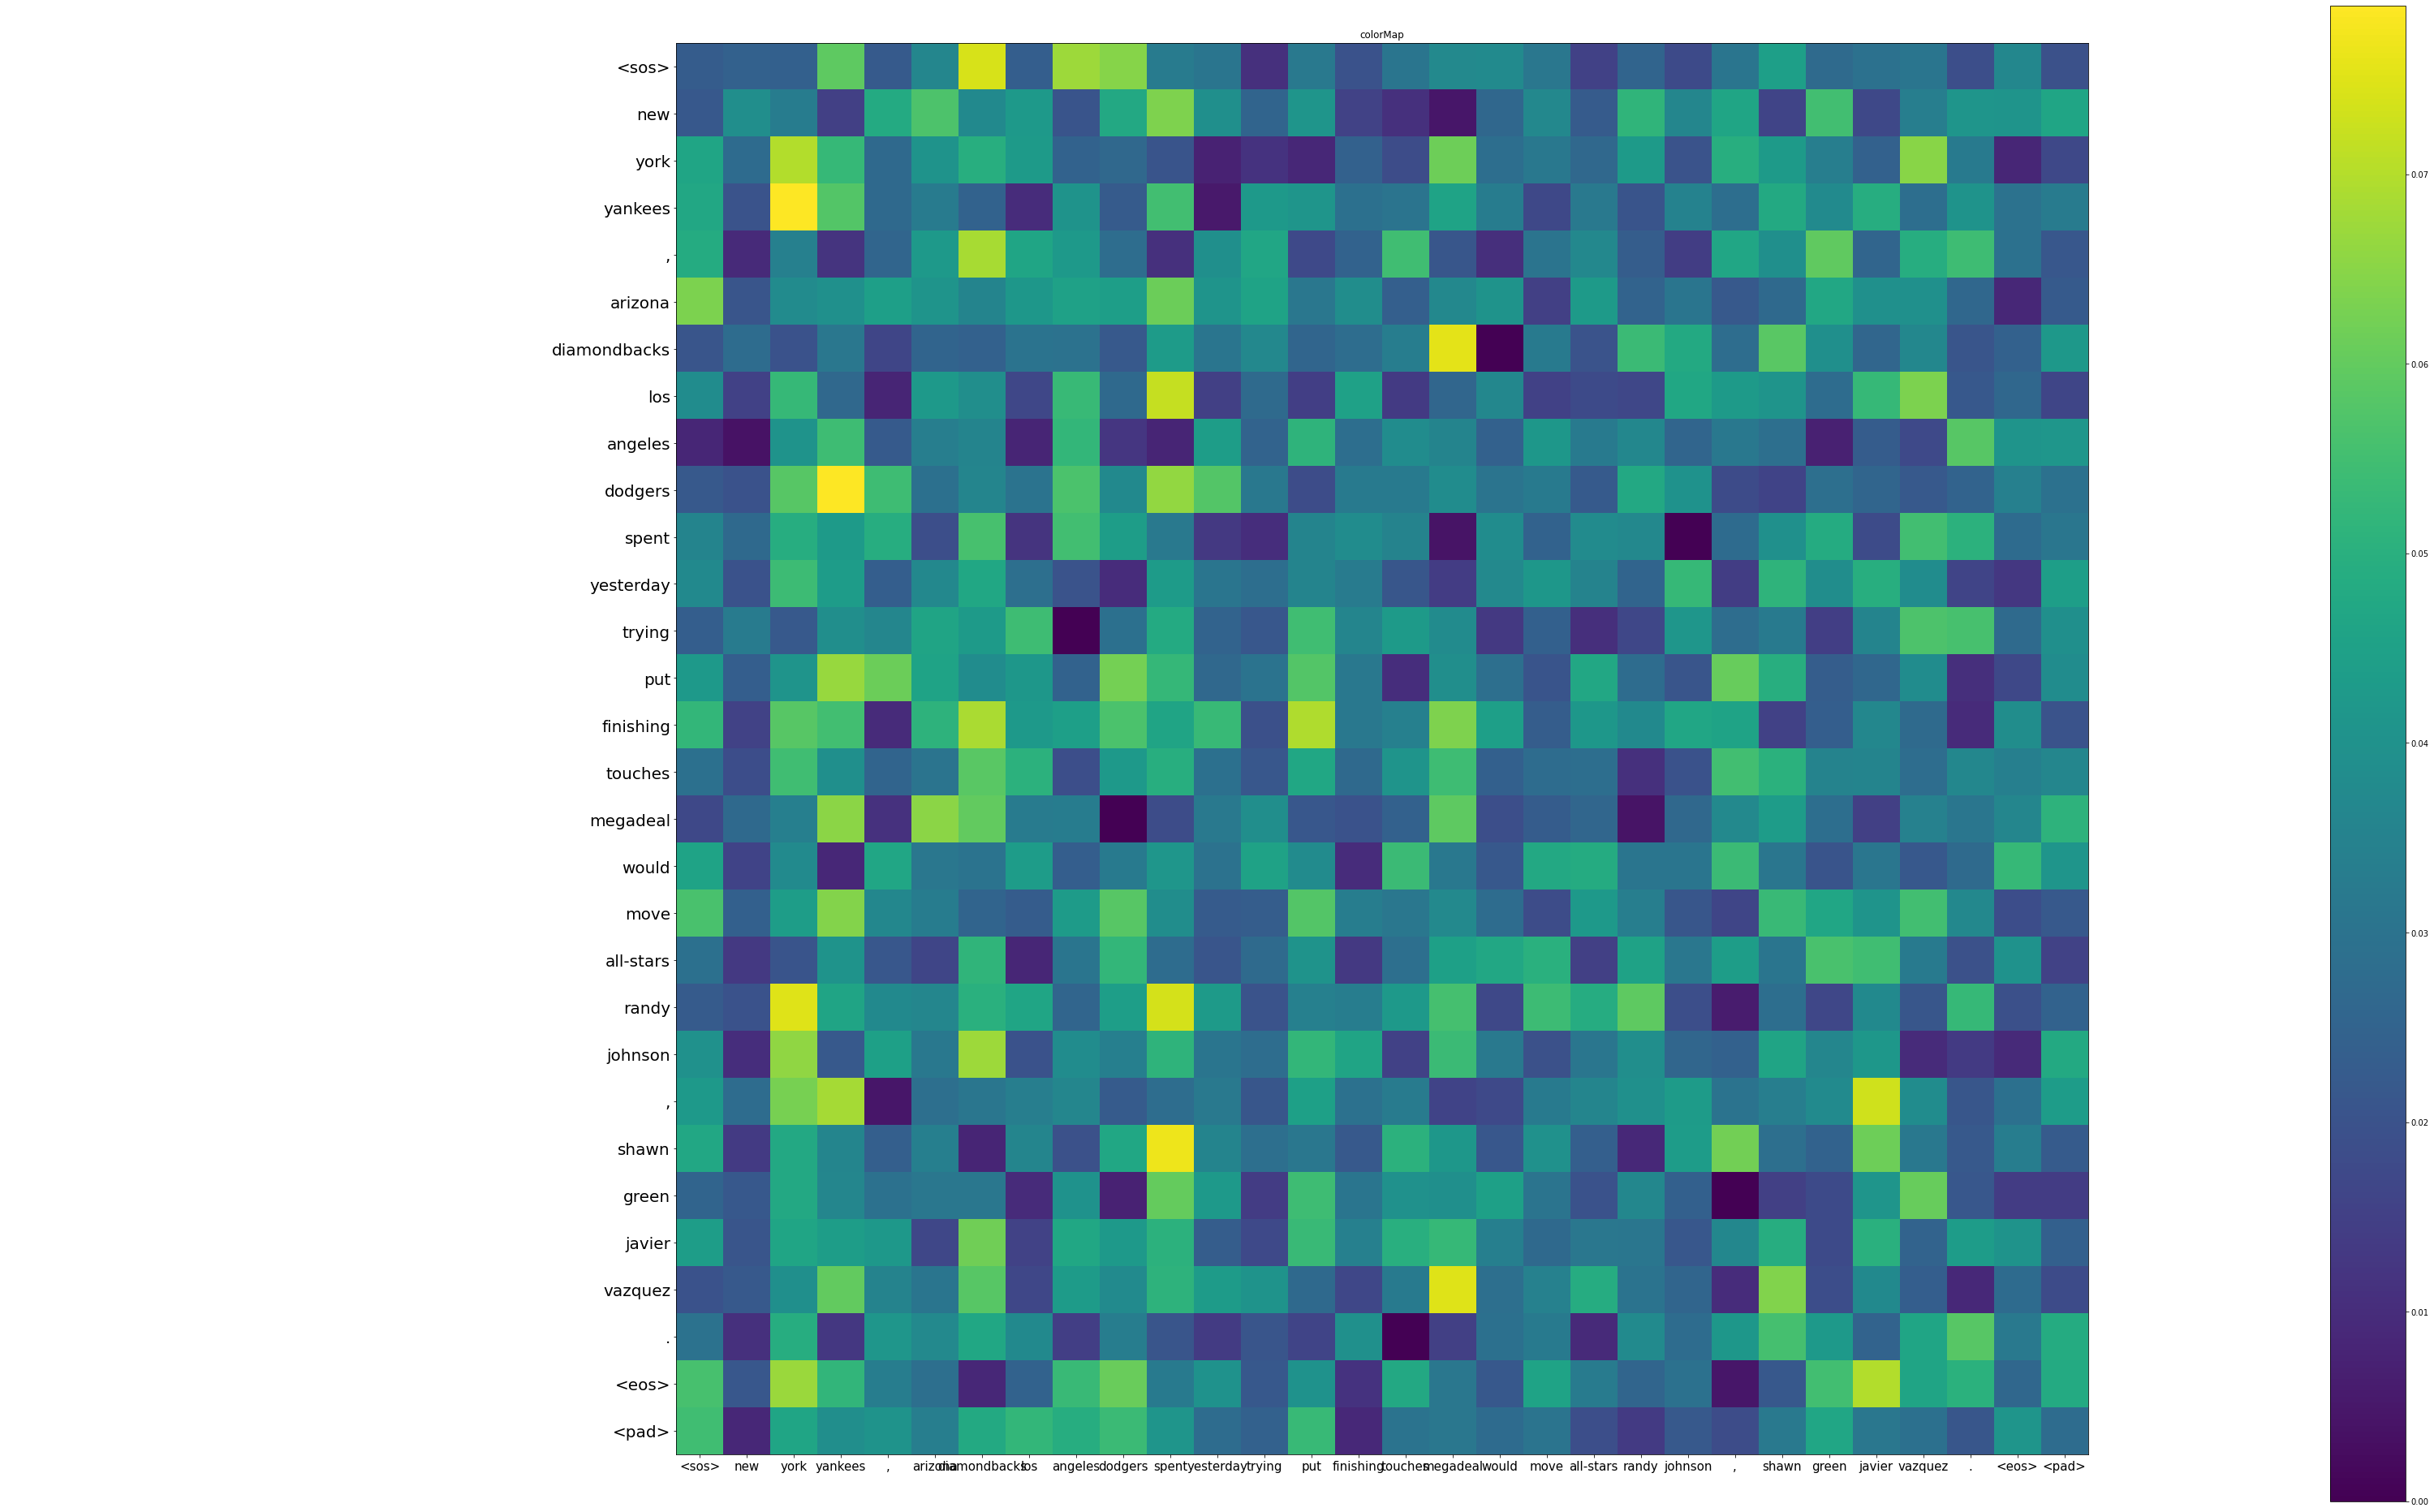

In [367]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(60, 32))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(activation['attn_output_weights '].cpu().detach().numpy()[0])#best_model.transformer_encoder.layers[nlayers-1].self_attn.out_proj.weight.cpu().detach().numpy())
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

column_labels = word
row_labels = word
ax.set_xticks(list(range(30)))
ax.set_yticks(list(range(30)), )
ax.set_xticklabels(column_labels,fontsize=15)#, minor=False)
ax.set_yticklabels(row_labels, fontsize=20)#, minor=False)

plt.show()

# Training

In [183]:
best_model = None

In [241]:
import copy
from tqdm import tqdm
epochs = 200

criterion = nn.CrossEntropyLoss()#label_smoothing = 0.01)
min_loss = 0.45

#torch.manual_seed(0)
max_acc = 0
print("starting")
for epoch in range(epochs):
    if epoch<10:
      lr = 0.000001 + ((0.001-0.000001)*epoch)/10
      optimizer = torch.optim.AdamW(
          (p for p in model.parameters() if p.requires_grad), lr=lr
      )
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5)
    elif epoch==10:
      lr = 0.00001
      optimizer = torch.optim.AdamW(
          (p for p in model.parameters() if p.requires_grad), lr=lr
      )
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5)
    epoch_loss = 0
    epoch_correct = 0
    epoch_count = 0
    for idx, batch in enumerate(iter(train_iter)):
        #print(batch.Description.shape)
        predictions = model(batch.Description.to(device))
        labels = batch.Category.to(device) - 1
        #print(labels)
        #print(predictions.size(), labels.size())
        loss = criterion(predictions, labels)
        
        correct = predictions.argmax(axis=1) == labels
        acc = correct.sum().item() / correct.size(0)

        epoch_correct += correct.sum().item()
        epoch_count += correct.size(0)

        epoch_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        optimizer.step()

    scheduler.step(epoch_loss)
    with torch.no_grad():
        test_epoch_loss = 0
        test_epoch_correct = 0
        test_epoch_count = 0

        for idx, batch in enumerate(iter(val_iter)):
            predictions = model(batch.Description.to(device))
            labels = batch.Category.to(device) - 1
            test_loss = criterion(predictions, labels)

            correct = predictions.argmax(axis=1) == labels
            acc = correct.sum().item() / correct.size(0)

            test_epoch_correct += correct.sum().item()
            test_epoch_count += correct.size(0)
            test_epoch_loss += test_loss.item()
        if(test_epoch_loss/len(val_iter))<min_loss:
            print("save")
            min_loss = test_epoch_loss/len(val_iter)
            best_model = copy.deepcopy(model)
    print('-' * 100)
    print(f'| end of epoch {epoch:3d} | training loss: {epoch_loss/len(train_iter):5.2f} |'
          f'valid loss {test_epoch_loss/len(val_iter):5.2f} | training acc: {epoch_correct/epoch_count:5.2f}  | valid acc {(test_epoch_correct / test_epoch_count):8.2f}')
    print('-' * 100)
     

starting
----------------------------------------------------------------------------------------------------
| end of epoch   0 | training loss:  1.39 |valid loss  1.40 | training acc:  0.31  | valid acc     0.31
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| end of epoch   1 | training loss:  1.33 |valid loss  1.29 | training acc:  0.35  | valid acc     0.43
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
| end of epoch   2 | training loss:  1.20 |valid loss  1.10 | training acc:  0.53  | valid acc     0.66
----------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------

In [244]:
def test(test_iter):
   with torch.no_grad():
        test_epoch_loss = 0
        test_epoch_correct = 0
        test_epoch_count = 0

        for idx, batch in enumerate(iter(test_iter)):
            predictions = best_model(batch.Description.to(device))
            labels = batch.Category.to(device) - 1
            test_loss = criterion(predictions, labels)

            correct = predictions.argmax(axis=1) == labels
            acc = correct.sum().item() / correct.size(0)

            test_epoch_correct += correct.sum().item()
            test_epoch_count += correct.size(0)
            test_epoch_loss += test_loss.item()
        return test_epoch_loss/len(test_iter), (test_epoch_correct / test_epoch_count)
train_loss, train_acc = test(train_iter)
val_loss, val_acc = test(val_iter)
print(f'| training loss: {train_loss:5.2f} |'
          f'valid loss {val_loss:5.2f} | training acc: {train_acc:5.2f}  | valid acc {val_acc:8.2f}')

     

| training loss:  0.38 |valid loss  0.49 | training acc:  0.87  | valid acc     0.84


In [245]:
torch.save(best_model, 'best.pt')

# Output submission file

In [ ]:
"""df = pd.read_csv("test.csv")
review = df["Description"].tolist()
reviews = [line.strip().split() for line in review]
print(reviews[0])
reviews = np.asarray(reviews, dtype="int64")"""
id = 1
id_list = []
for batch in iter(test_iter):
    prediction = best_model(batch.Description.to(device))
    #print(prediction.size())
    #index = np.argmax(prediction.cpu().detach().numpy(), axis = 1)
    index = prediction.cpu().detach().numpy().argmax(axis=1)
    for i, c in enumerate(index):
      id_list.append((int(batch.Id[i]), c+1))
      #writer.writerow([str(batch.Id[i]), str(c+1)])
     

id_list

In [247]:
def takeFirst(elem):
    return elem[0]

id_list.sort(key=takeFirst)

In [248]:


with open('output2.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['Id', 'Category'])
  output = []
  for (id, label) in id_list:
      writer.writerow([id, label])


In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# 1.1 Discussion 

## (1) Using spacy

In [ ]:
from spacy.lang.en import English

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()

sentence = "Its net income during the June to September period was 2.69tr won (1.2bn), 46 up on the same period a year earlier. During the period, which is Samsung Electronics #39; fiscal third quarter, the company said "
#  "nlp" Object is used to create documents with linguistic annotations.
my_doc = nlp(sentence)

# Create list of word tokens
token_list = []
for token in my_doc:
    token_list.append(token.text)
token_list

['Its',
 'net',
 'income',
 'during',
 'the',
 'June',
 'to',
 'September',
 'period',
 'was',
 '2.69tr',
 'won',
 '(',
 '1.2bn',
 ')',
 ',',
 '46',
 'up',
 'on',
 'the',
 'same',
 'period',
 'a',
 'year',
 'earlier',
 '.',
 'During',
 'the',
 'period',
 ',',
 'which',
 'is',
 'Samsung',
 'Electronics',
 '#',
 '39',
 ';',
 'fiscal',
 'third',
 'quarter',
 ',',
 'the',
 'company',
 'said']

## (2) Using ntlk

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sentence = "Its net income during the June to September period was 2.69tr won (1.2bn), 46 up on the same period a year earlier. During the period, which is Samsung Electronics #39; fiscal third quarter, the company said "
from nltk.tokenize import word_tokenize 
word_tokenize(sentence)

['Its',
 'net',
 'income',
 'during',
 'the',
 'June',
 'to',
 'September',
 'period',
 'was',
 '2.69tr',
 'won',
 '(',
 '1.2bn',
 ')',
 ',',
 '46',
 'up',
 'on',
 'the',
 'same',
 'period',
 'a',
 'year',
 'earlier',
 '.',
 'During',
 'the',
 'period',
 ',',
 'which',
 'is',
 'Samsung',
 'Electronics',
 '#',
 '39',
 ';',
 'fiscal',
 'third',
 'quarter',
 ',',
 'the',
 'company',
 'said']

In [ ]:
from torchtext.data.utils import get_tokenizer
sentence = "Its net income during the June to September period was 2.69tr won (1.2bn), 46 up on the same period a year earlier. During the period, which is Samsung Electronics #39; fiscal third quarter, the company said "
tokenizer = get_tokenizer('basic_english')
tokenizer(sentence)

['its',
 'net',
 'income',
 'during',
 'the',
 'june',
 'to',
 'september',
 'period',
 'was',
 '2',
 '.',
 '69tr',
 'won',
 '(',
 '1',
 '.',
 '2bn',
 ')',
 ',',
 '46',
 'up',
 'on',
 'the',
 'same',
 'period',
 'a',
 'year',
 'earlier',
 '.',
 'during',
 'the',
 'period',
 ',',
 'which',
 'is',
 'samsung',
 'electronics',
 '#39',
 'fiscal',
 'third',
 'quarter',
 ',',
 'the',
 'company',
 'said']

## (3) Using gensim

In [ ]:
from gensim.utils import tokenize
sentence = "Its net income during the June to September period was 2.69tr won (1.2bn), 46 up on the same period a year earlier. During the period, which is Samsung Electronics #39; fiscal third quarter, the company said "
list(tokenize(sentence))

['Its',
 'net',
 'income',
 'during',
 'the',
 'June',
 'to',
 'September',
 'period',
 'was',
 'tr',
 'won',
 'bn',
 'up',
 'on',
 'the',
 'same',
 'period',
 'a',
 'year',
 'earlier',
 'During',
 'the',
 'period',
 'which',
 'is',
 'Samsung',
 'Electronics',
 'fiscal',
 'third',
 'quarter',
 'the',
 'company',
 'said']

## (4) Using Python’s split() 

In [ ]:
sentence = "Its net income during the June to September period was 2.69tr won (1.2bn), 46 up on the same period a year earlier. During the period, which is Samsung Electronics #39; fiscal third quarter, the company said "
sentence.strip().split()

['Its',
 'net',
 'income',
 'during',
 'the',
 'June',
 'to',
 'September',
 'period',
 'was',
 '2.69tr',
 'won',
 '(1.2bn),',
 '46',
 'up',
 'on',
 'the',
 'same',
 'period',
 'a',
 'year',
 'earlier.',
 'During',
 'the',
 'period,',
 'which',
 'is',
 'Samsung',
 'Electronics',
 '#39;',
 'fiscal',
 'third',
 'quarter,',
 'the',
 'company',
 'said']

## Plot attention map

In [ ]:

for name, para in best_model.named_parameters():
    if "transformer_encoder.layers.1.self_attn.out_proj.weight" in name:
        weights = para

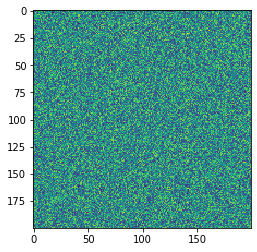

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(weights.cpu().detach().numpy(), interpolation='none')
plt.show()